In [4]:
from pathlib import Path

import numpy as np
import cv2
import sklearn
import sklearn.cluster
import matplotlib.pyplot as plt
import skimage
import pyefd
import tqdm

import seed_detector.tools as sdt
from seed_detector.tools import resample_polygon, polygon_area, get_contours
def reset_starting_point(contour):
    best_i = 0
    best_d = np.inf
    mid_x = (contour[:, 1].max() - contour[:, 1].min()) / 2 + contour[:, 1].min()
    mid_y = (contour[:, 0].max() - contour[:, 0].min()) / 2 + contour[:, 0].min()
    for i in range(contour.shape[0]):
        d = np.abs(contour[i, 1] - mid_x)
        if d < best_d and contour[i, 0] < mid_y:
            best_d = d
            best_i = i
    return np.r_[contour[best_i:, ], contour[:best_i, ]]

In [5]:
mask_files = list(Path('./test_align/').rglob('*/masks/*.png'))

contours = []
for mask_file in tqdm.tqdm(mask_files):
    mask = cv2.imread(str(mask_file), cv2.IMREAD_UNCHANGED)
    c = get_contours(mask, 1)
    if len(c) < 1:
        print(f'Could not find contour in {mask_file}.')
        continue
    contour = sorted(c, key=lambda c: c.shape[0])[0]
    contour = reset_starting_point(contour)
    contour = resample_polygon(contour, 50)
    contours.append(contour)

 64%|███████████████████████▊             | 65980/102480 [01:20<00:45, 805.53it/s]

Could not find contour in test_align/Scannen0108_cal/masks/Scannen0108_cal_36_mask.png.


 84%|██████████████████████████████▍     | 86566/102480 [01:41<00:11, 1356.04it/s]

Could not find contour in test_align/Scannen1276_cal/masks/Scannen1276_cal_0_mask.png.


100%|████████████████████████████████████| 102480/102480 [01:56<00:00, 877.69it/s]


In [7]:
pca = sklearn.decomposition.PCA(2)
pca.fit(x)
r = pca.transform(x)

PCA(n_components=2)

In [28]:
from sklearn.cluster import KMeans

k=10
km = KMeans(n_clusters=k)
km.fit(r)
cl = km.predict(r)

KMeans(n_clusters=10)

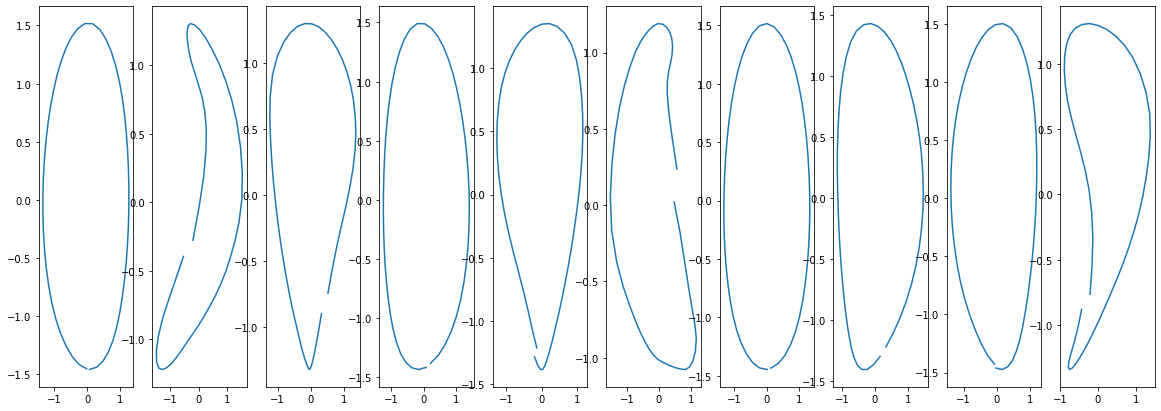

In [33]:
fig, axs = plt.subplots(1, k, figsize=[20, 7])
for i in range(k):
    r1 = r[cl == i,:]
    m1 = pca.inverse_transform(r1.mean(axis=0)).reshape(-1, 2)
    axs[i].plot(m1[:, 1], m1[:, 0])

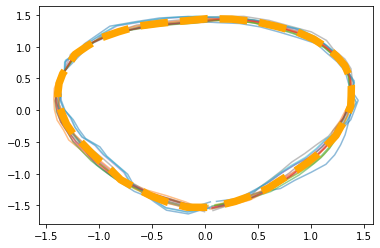

In [17]:
mask_dir = Path('./test_align/Scannen0025_cal/masks/')
mask_files = list(mask_dir.glob('*.png'))

contours = []
for mask_file in mask_files:
    mask = cv2.imread(str(mask_file), cv2.IMREAD_UNCHANGED)
    contour = sorted(get_contours(mask, 1), key=lambda c: c.shape[0])[0]
    contour = reset_starting_point(contour)
    contour = resample_polygon(contour, 50)
    contours.append(contour)
    
x = np.array([((c - c.mean(0)) / c.std(0)).ravel() for c in contours])
# x = (x - x.mean(axis=0)) / x.std(axis=0)

pca = sklearn.decomposition.PCA(2)
pca.fit(x)

r = [r for r in pca.transform(x)]
for i in range(len(r)):
    plt.plot(pca.inverse_transform(r[i]).reshape(-1, 2)[:, 1], pca.inverse_transform(r[i]).reshape(-1, 2)[:, 0], alpha=0.5)

rc = pca.inverse_transform(np.array(r).mean(0)).reshape(-1, 2)
plt.plot(rc[:, 1], rc[:, 0], '--',color='orange', linewidth=7.5, alpha=1)

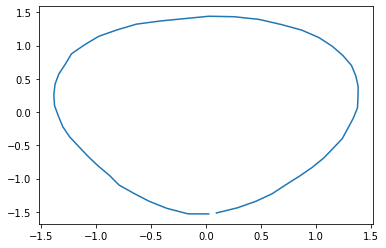

In [9]:
plt.plot(pca.inverse_transform(r).mean(0).reshape(-1,2)[:, 1], pca.inverse_transform(r).mean(0).reshape(-1,2)[:, 0])

In [181]:
image_path = Path('./test2/Scannen0001/extractions/Scannen0001_bbox0.png')
mask_path = Path('./test2/Scannen0001/masks/Scannen0001_mask0.png')

image = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED) != 0
mask = mask.astype(int)

[ WARN:0@4288.518] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('test2/Scannen0001/extractions/Scannen0001_bbox0.png'): can't open/read file: check file path/integrity
[ WARN:0@4288.520] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('test2/Scannen0001/masks/Scannen0001_mask0.png'): can't open/read file: check file path/integrity


AttributeError: 'bool' object has no attribute 'astype'

In [45]:
def get_contour(image, n = 200):
    bg_col = (0, 0, 0)
    bin_image = (image != bg_col).all(axis=2)

    contours, hierarchy = cv2.findContours(
        bin_image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
    )
    contours = [c[:, -1, [1, 0]] for c in contours]
    contour = contours[0]
    contour = resample_polygon(contour, n)
    
    return contour

def plot_points(xy, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(xy[:, 0], xy[:, 1])
    
def plot_box(xy, ax=None, box_type='ellipse'):
    if ax is None:
        ax = plt.gca()
    
    if box_type == 'box':
        box = cv2.minAreaRect(xy)
    elif box_type == 'ellipse':
        box = cv2.fitEllipse(xy)
    else:
        msg = f'Unknown box_type "{box_type}".'
        raise Exception(msg)
    box_xy = cv2.boxPoints(box)
    
    plot_points(box_xy)

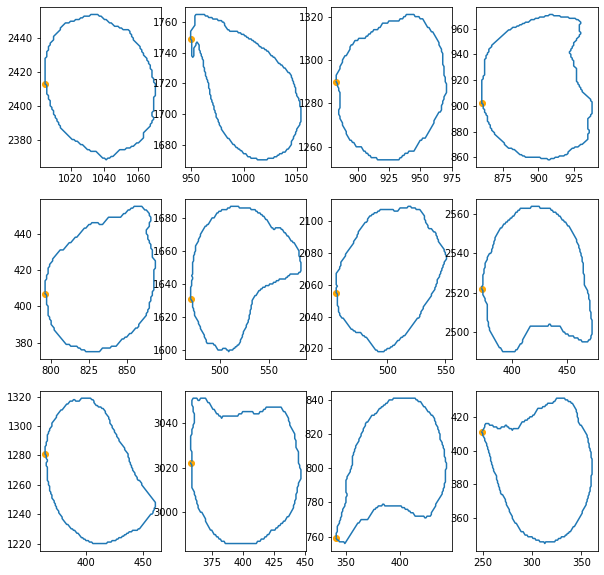

In [46]:
import seed_detector.tools as sdt

# mask_path = Path('./test/Scannen1140/Scannen1140_mask.png')
# mask_path = Path('./test/Scannen0101/Scannen0101_mask.png')
mask_path = Path('./test/Scannen0010/Scannen0010_mask.png')
# mask_path = Path('./test/Scannen0779/Scannen0779_mask.png')
# mask_path = Path('./test/Scannen0389/Scannen0389_mask.png')
mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
contours = sdt.get_contours(mask, 10)

n_contours = len(contours)

n_col = int(np.ceil(np.sqrt(n_contours)))

fig, axs = plt.subplots(int(np.ceil(n_contours / n_col)), n_col, figsize=(10, 10))
axs = axs.flatten()
for i, contour in enumerate(contours):
    axs[i].plot(contour[:, 0], contour[:, 1])
    axs[i].scatter(contour[0, 0], contour[0, 1], color='orange')

In [47]:
ref, _ = sdt.rotate_upright(contours[0])
ref_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(ref, order=3, normalize=False), num_points=100)

contours_rot = []
rots = []
for contour in contours:
    contour_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour, order=3, normalize=False), num_points=100)
    _, best_i, rotation, scale, _ = sdt.align_shapes(ref_approx, contour_approx)
    contour_approx_rot = contour_approx.dot(rotation.T)
    disparity = np.sum(np.square(ref_approx - contour_approx_rot))

    rots.append(np.arctan2(rotation.T[0, 0], rotation.T[1, 0]) * 180 / np.pi) 
    contour_rot = contour.dot(rotation.T)
    contour_rot = np.r_[contour_rot[best_i:,], contour_rot[:best_i,]]
    contours_rot.append(contour_rot)

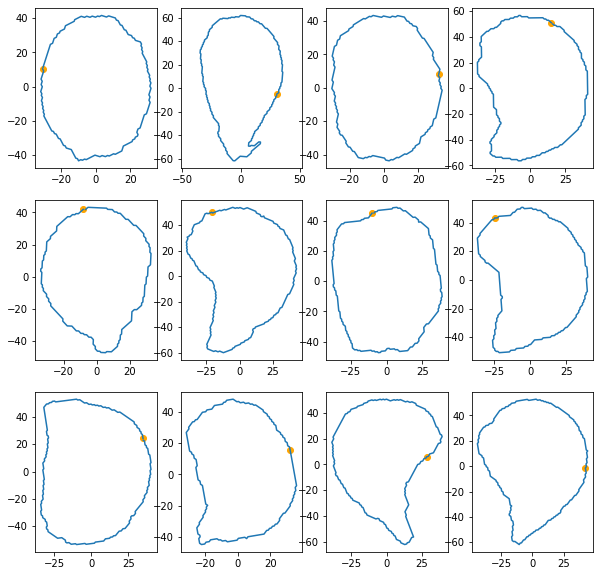

In [48]:
n_col = int(np.ceil(np.sqrt(n_contours)))

fig, axs = plt.subplots(int(np.ceil(n_contours / n_col)), n_col, figsize=(10,10))
axs = axs.flatten()
for i, contour in enumerate(contours_rot):
    c = contour - contour.mean(0)
    axs[1].axis('equal')
    axs[i].plot(c[:, 0], c[:, 1])
    axs[i].scatter(c[0, 0], c[0, 1], color='orange')

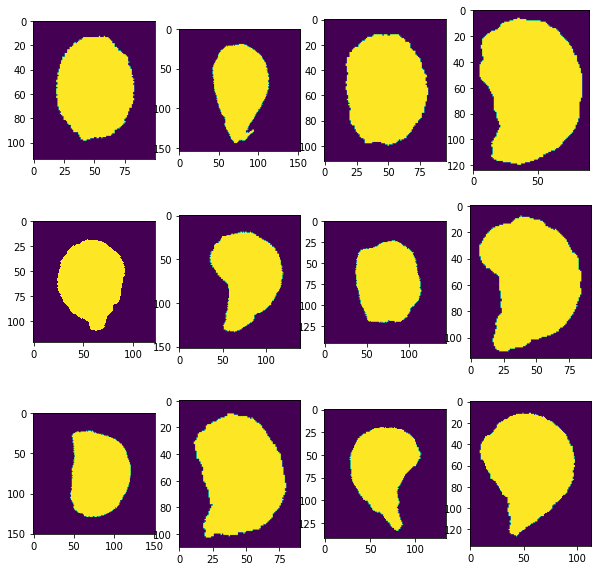

In [49]:
n_col = int(np.ceil(np.sqrt(n_contours)))

fig, axs = plt.subplots(int(np.ceil(n_contours / n_col)), n_col, figsize=(10,10))
axs = axs.flatten()
for i, contour in enumerate(contours):
    angle = rots[i]
    sub_img, *_ = sdt.extract_subimage(contour, mask)
    axs[i].imshow(skimage.transform.rotate(sub_img, angle, resize=True, order=0))

In [50]:
import seed_detector.tools as sdt

# mask_path = Path('./test/Scannen1140/Scannen1140_mask.png')
# mask_path = Path('./test/Scannen0101/Scannen0101_mask.png')
# mask_path = Path('./test/Scannen0010/Scannen0010_mask.png')
# mask_path = Path('./test/Scannen0779/Scannen0779_mask.png')
image_name = 'Scannen0389'
result_dir = Path('./test')
mask_path = result_dir / image_name / f'{image_name}_mask.png'
extraction_path = result_dir / image_name / f'{image_name}_mask.png'
mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
contours = sdt.get_contours(mask, 10)

n_contours = len(contours)

n_col = int(np.ceil(np.sqrt(n_contours)))

fig, axs = plt.subplots(int(np.ceil(n_contours / n_col)), n_col, figsize=(10, 10))
axs = axs.flatten()
for i, contour in enumerate(contours):
    axs[i].plot(contour[:, 0], contour[:, 1])
    axs[i].scatter(contour[0, 0], contour[0, 1], color='orange')

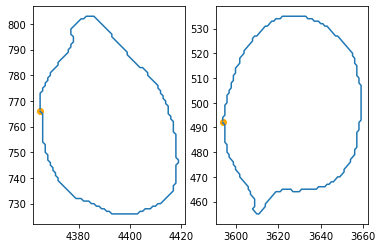

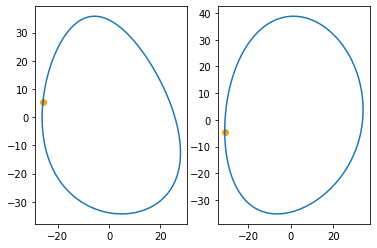

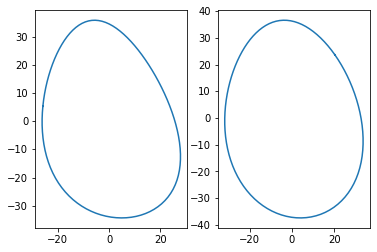

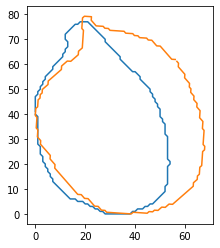

In [ ]:
contour1 = contours[0]
contour2 = contours[8]

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1[:, 0], contour1[:, 1])
axs[0].scatter(contour1[0, 0], contour1[0, 1], color='orange')
axs[1].plot(contour2[:, 0], contour2[:, 1])
axs[1].scatter(contour2[0, 0], contour2[0, 1], color='orange')

 
contour1_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour1, order=2, normalize=False), num_points=100)
contour2_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour2, order=2, normalize=False), num_points=100)

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1_approx[:, 0], contour1_approx[:, 1])
axs[0].scatter(contour1_approx[0, 0], contour1_approx[0, 1], color='orange')
axs[1].plot(contour2_approx[:, 0], contour2_approx[:, 1])
axs[1].scatter(contour2_approx[0, 0], contour2_approx[0, 1], color='orange')

_, best_i, rotation, scale, _ = match_shapes(contour1_approx, contour2_approx)

contour1_approx_rot = contour1_approx.copy()
contour2_approx_rot = contour2_approx.dot(rotation.T)
disparity = np.sum(np.square(contour1_approx_rot - contour2_approx_rot))

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1_approx_rot[:, 0], contour1_approx_rot[:, 1])
axs[1].plot(contour2_approx_rot[:, 0], contour2_approx_rot[:, 1])


fig, ax = plt.subplots(1,1)
ax.set_aspect('equal')
ax.plot(contour1[:, 0] - min(contour1[:, 0]), contour1[:, 1] - min(contour1[:, 1]))
contour2_rot = contour2.dot(rotation.T)
ax.plot(contour2_rot[:, 0] - min(contour2_rot[:, 0]), contour2_rot[:, 1] - min(contour2_rot[:, 1]))

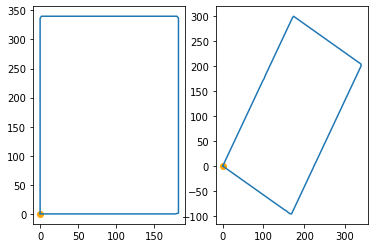

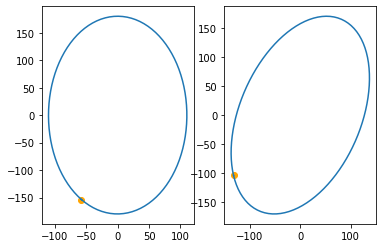

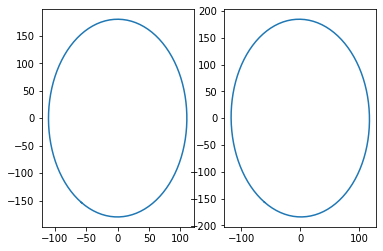

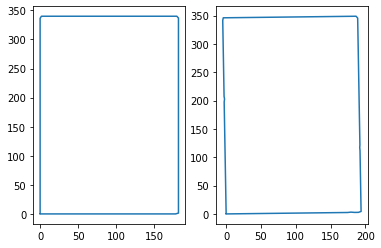

In [ ]:
image_path1 = Path('./test/Scannen1140/extractions/Scannen1140_bbox0.png')
image1 = cv2.cvtColor(cv2.imread(str(image_path1)), cv2.COLOR_BGR2RGB)
contour1 = get_contour(image1)

image_path2 = Path('./test/Scannen1140/extractions/Scannen1140_bbox9.png')
image2 = cv2.cvtColor(cv2.imread(str(image_path2)), cv2.COLOR_BGR2RGB)
contour2 = get_contour(image2)
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c)))
contour2 = contour2.dot(R)


fig, axs = plt.subplots(1,2)
axs[0].plot(contour1[:, 0], contour1[:, 1])
axs[0].scatter(contour1[0, 0], contour1[0, 1], color='orange')
axs[1].plot(contour2[:, 0], contour2[:, 1])
axs[1].scatter(contour2[0, 0], contour2[0, 1], color='orange')

 
contour1_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour1, order=2, normalize=False), num_points=100)
contour2_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour2, order=2, normalize=False), num_points=100)

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1_approx[:, 0], contour1_approx[:, 1])
axs[0].scatter(contour1_approx[0, 0], contour1_approx[0, 1], color='orange')
axs[1].plot(contour2_approx[:, 0], contour2_approx[:, 1])
axs[1].scatter(contour2_approx[0, 0], contour2_approx[0, 1], color='orange')


# rotation, scale = orthogonal_procrustes(contour1_approx, contour2_approx)

# contour1_rot = contour1_approx.copy()
# contour2_rot = contour2_approx.dot(rotation.T)
# disparity = np.sum(np.square(contour1_rot - contour2_rot))


_, best_i, rotation, scale, _ = match_shapes(contour1_approx, contour2_approx)

contour1_approx_rot = contour1_approx.copy()
contour2_approx_rot = contour2_approx.dot(rotation.T)
disparity = np.sum(np.square(contour1_approx_rot - contour2_approx_rot))

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1_approx_rot[:, 0], contour1_approx_rot[:, 1])
axs[1].plot(contour2_approx_rot[:, 0], contour2_approx_rot[:, 1])


fig, axs = plt.subplots(1,2)
axs[0].plot(contour1[:, 0], contour1[:, 1])
contour2_rot = contour2.dot(rotation.T)
axs[1].plot(contour2_rot[:, 0], contour2_rot[:, 1])

In [ ]:
r = match_shapes(contour1_approx, np.r_[contour2_approx[5:,], contour2_approx[:5,]])